In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/home/aiffel-dj40/aiffel/ocr


몇 개의 Class가 필요한지 확인하기 위해 다음 셀을 실행한 후 퀴즈를 풀어보세요.

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


아래에 필요한 라이브러리들을 import하도록 합니다. 다운로드한 MJ 데이터셋의 위치도 확인해서 옮겨주세요!

In [3]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

# 로컬 사용자
TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

# 클라우드 사용자는 아래 주석을 사용해 주세요.
# TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
# VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
# TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'
print(TRAIN_DATA_PATH)

/home/aiffel-dj40/aiffel/ocr/MJ/MJ_train


그럼 데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인해 봅시다. 아래는 lmdb를 통해 훈련데이터셋의 이미지를 4개만 열어서 실제 shape가 어떻게 생겼는지, 이미지나 라벨은 어떻게 달려 있는지를 확인해 보도록 합시다.

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


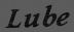

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


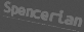

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


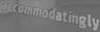

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


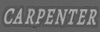

In [4]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

대부분의 이미지의 height는 31, 최대 32까지로 되어 있고, width는 문자열 길이에 따라 다양한 것으로 보입니다.

1. lmdb를 활용하여 케라스 모델 학습용 MJ Synth 데이터셋 클래스를 구현하려 함.  
2. dataset_path는 읽어들일 데이터셋의 경로  
3. label_converter는 아래에서 여러분이 문자를 미리정의된 index로 변환  
4. batch_size와 입력이미지 크기  
5. 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있습니다.

1. 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 `_get_img_label()` 메소드에 반영  
2. `model.fit()`에서 호출되는 `__getitem__()` 메소드에서 배치 단위만큼 `_get_img_label()` 를 통해 가져온 데이터셋을 리턴하게 될 것  
3. `_get_img_label()` 를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공하고 있습니다.

In [5]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 가져오는 메소드
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    # idx번째 배치를 가져오는 메소드
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

1. Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있다. -> 적절한 형태 아님 -> 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 합니다. 이를 해줄 수 있는 LabelConverter 클래스를 작성해봅시다.  


- __init__() 에서는 입력으로 받은 text를 self.dict에 각 character들이 어떤 index에 매핑되는지 저장합니다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어집니다. 만약 character='ABCD'라면 'A'의 label은 1, 'B'의 label은 2가 됩니다.  
- 공백(blank) 문자를 지정합니다. 여기서는 공백 문자를 뜻하기 위해 '-'를 활용하며, label은 0으로 지정합니다.  
- decode()는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어줍니다.  



In [6]:
class LabelConverter(object):
     """ Convert between text-label and text-index """

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label


아래에서 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인해보도록 해보세요!

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


이제 입력과 출력을 준비했으니 모델을 만들어볼 차례입니다. Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func를 아래와 같이 만들어두었습니다.

In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

`K.ctc_batch_cost(y_true, y_pred, input_length, label_length)`에는 4가지 인자가 존재합니다. 각각의 인자의 의미는 다음과 같습니다.

- `y_true`: tensor (samples, max_string_length) containing the truth labels.  
- `y_pred`: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.  
- `input_length tensor`: (samples, 1) containing the sequence length for each batch item in y_pred.  
- `label_length tensor`: (samples, 1) containing the sequence length for each batch item in y_true.  

![image](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GC-6-P-example.png)  


- `y_true`: 실제 라벨 LUBE. 그러나 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정  
- `y_pred`: 우리가 만들 RCNN 모델의 출력 결과. 그러나 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정  
- `input_length tensor`: 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 74  
- `label_length tensor`: 라벨의 실제 정답 길이 U로서, 이 경우에는 4  

`K.ctc_batch_cost()`를 활용하여, `image_input`을 입력으로 그리고 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 `build_crnn_model()`을 구현  
    

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    # [[YOUR CODE]]
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

이제 앞에서 정의한 `MJDatasetSequence`로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 시켜봅시다. 우리는 시간이 많지 않으니 적절한 Epoch를 설정하여 모델을 학습시켜봅시다! 1Epoch에 10초 정도 소요될 것입니다.

In [10]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=100,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

Epoch 1/100
63/63 [==============================] - 32s 161ms/step - loss: 33.4102 - val_loss: 26.9414

Epoch 00001: val_loss improved from inf to 26.94144, saving model to /home/aiffel-dj40/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/100
63/63 [==============================] - 9s 136ms/step - loss: 26.6863 - val_loss: 26.2800

Epoch 00002: val_loss improved from 26.94144 to 26.27998, saving model to /home/aiffel-dj40/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/100
63/63 [==============================] - 9s 138ms/step - loss: 25.9508 - val_loss: 26.4300

Epoch 00003: val_loss did not improve from 26.27998
Epoch 4/100
63/63 [==============================] - 8s 129ms/step - loss: 25.8714 - val_loss: 25.8222

Epoch 00004: val_loss improved from 26.27998 to 25.82221, saving model to /home/aiffel-dj40/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/100
63/63 [==============================] - 9s 136ms/step - loss: 25.4876 - val_loss: 25.4890

Epoch 00005: val_loss improved from 25.82221 to 25.48901,

63/63 [==============================] - 8s 129ms/step - loss: 4.7641 - val_loss: 5.0514

Epoch 00040: val_loss improved from 5.20293 to 5.05143, saving model to /home/aiffel-dj40/aiffel/ocr/model_checkpoint.hdf5
Epoch 41/100
63/63 [==============================] - 8s 129ms/step - loss: 4.8113 - val_loss: 5.0218

Epoch 00041: val_loss improved from 5.05143 to 5.02178, saving model to /home/aiffel-dj40/aiffel/ocr/model_checkpoint.hdf5
Epoch 42/100
63/63 [==============================] - 9s 135ms/step - loss: 4.6805 - val_loss: 4.9915

Epoch 00042: val_loss improved from 5.02178 to 4.99147, saving model to /home/aiffel-dj40/aiffel/ocr/model_checkpoint.hdf5
Epoch 43/100
63/63 [==============================] - 8s 130ms/step - loss: 4.8496 - val_loss: 4.9007

Epoch 00043: val_loss improved from 4.99147 to 4.90065, saving model to /home/aiffel-dj40/aiffel/ocr/model_checkpoint.hdf5
Epoch 44/100
63/63 [==============================] - 8s 130ms/step - loss: 4.4454 - val_loss: 4.7035

Epoch 

Epoch 84/100
63/63 [==============================] - 8s 130ms/step - loss: 3.0709 - val_loss: 3.3570

Epoch 00084: val_loss did not improve from 3.27224
Epoch 85/100
63/63 [==============================] - 9s 134ms/step - loss: 3.2325 - val_loss: 3.4084

Epoch 00085: val_loss did not improve from 3.27224
Epoch 86/100
63/63 [==============================] - 8s 129ms/step - loss: 3.1245 - val_loss: 3.2401

Epoch 00086: val_loss improved from 3.27224 to 3.24007, saving model to /home/aiffel-dj40/aiffel/ocr/model_checkpoint.hdf5
Epoch 87/100
63/63 [==============================] - 8s 129ms/step - loss: 3.0512 - val_loss: 3.2797

Epoch 00087: val_loss did not improve from 3.24007
Epoch 88/100
63/63 [==============================] - 8s 129ms/step - loss: 2.9493 - val_loss: 3.3032

Epoch 00088: val_loss did not improve from 3.24007
Epoch 89/100
63/63 [==============================] - 9s 135ms/step - loss: 3.1027 - val_loss: 3.1389

Epoch 00089: val_loss improved from 3.24007 to 3.13888,

이제 학습한 모델을 테스트셋에서 inference해보고 이를 눈으로 직접 확인해보세요!

Result: 	 SLINKING9999999999999999


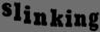

Result: 	 ALEPPO99999999999999999


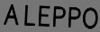

Result: 	 RWANDA999999999999999999


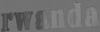

Result: 	 NATHANS99999999999999999


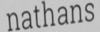

Result: 	 HALLEO99999999999999999


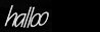

Result: 	 HURLS9999999999999999999


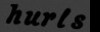

Result: 	 DOWNSIZE9999999999999999


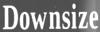

Result: 	 ROBOTIC99999999999999999


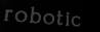

Result: 	 SLOPPY99999999999999999


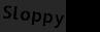

Result: 	 HERMITE99999999999999999


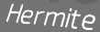

In [11]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

## 프로젝트: End-to-End OCR
![sample](https://aiffelstaticprd.blob.core.windows.net/media/images/e-23-4.sample.max-800x600.jpg)  

keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들어보도록 하겠습니다. 이를 위해서 keras-ocr을 설치해주고 Detector를 만들어주세요. 위의 사진 `sample.jpg`도 `ocr`폴더에 다운받으셔야합니다.

**이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 만들어보세요! inference한 후에는 이를 시각화하도록 합니다. 그리고 단어의 영역을 잘라오도록 해주세요.**

In [19]:
import matplotlib.pyplot as plt
import keras_ocr
import cv2

In [15]:
def detect_text(img_path):
    pipeline = keras_ocr.pipeline.Pipeline()
    
    images = keras_ocr.tools.read(img_path)
    predictions = pipeline.recognize([img_path])
    
    result_img = keras_ocr.tools.drawAnnotations(image=images, predictions=predictions[0])

    cropped_imgs = []
    revised_boxes = []
    for _, box in predictions[0]:
        revised_boxes.append(box)
    boxes = revised_boxes

    
    for box in boxes:
        cropped_imgs.append(keras_ocr.tools.warpBox(image=images, box=box))


    return result_img, cropped_imgs

Looking for /home/aiffel-dj40/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel-dj40/.keras-ocr/crnn_kurapan.h5


/home/aiffel-dj40/Downloads/exit/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


<AxesSubplot:>

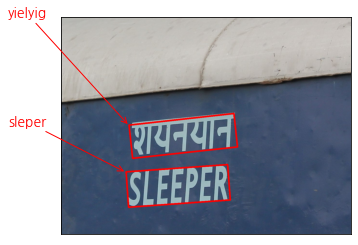

In [20]:
SAMPLE_IMG_PATH = os.getenv('HOME') + '/aiffel/ocr/sample.jpg'
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

이제 위에서 이미지 내의 단어 이미지를 얻었습니다. **그럼 Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해보세요!**

In [21]:
def recognize_img(pil_img, input_img_size=(100,32)):
    img90 = cv2.rotate(pil_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_flip = cv2.flip(img90, 0)
    pil_img = cv2.resize(img_flip, (32, 100), interpolation = cv2.INTER_CUBIC)
    img = pil_img.reshape(1, 100, 32, 3)
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

Result: 	 WGTEI9999999999999999999


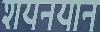

Result: 	 SLEEPER9999999999999999


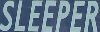

In [22]:
for _img in cropped_img:
    recognize_img(_img)

# 루브릭 평가
|평가문항|상세기준|
|:---|:---|
|1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.|텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.|
|2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.|학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.|
|3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.|샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.|